In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(tidymodels)
library(survival)
library(cowplot)
library(glmnet)
library(ggrepel)
library(geomtextpath)
})
theme_set(theme_cowplot())
options(repr.plot.width = 15, repr.plot.height = 9)
set.seed(42)

# Regularized Cox Regression 

In [2]:
data <- 
na.omit(pbc) |> # remove rows with missing data
mutate(surv=Surv(time, status==2)) # the surv variable will be our outcome
dim(data)

[1] 276  21

In [3]:
# separate 20% of the dataset for testing the models later
data_split <- initial_split(data, prop = 0.8, strata=time)

In [4]:
rec <- recipe(surv ~ ., data=data) |>
    step_rm(time, status, id) |>
    step_dummy(all_nominal_predictors()) |> 
    step_nzv(all_predictors())

In [5]:
prep_rec <- prep(rec)

In [6]:
train_data <-
    prep_rec |>
    bake(new_data=training(data_split))

In [7]:
train_data_x <- select(train_data, -surv)

In [8]:
cvfit <- cv.glmnet(as.matrix(train_data_x), train_data$surv, family = "cox", type.measure = "C", nfolds = 10, alpha=1)

In [9]:
cvfit


Call:  cv.glmnet(x = as.matrix(train_data_x), y = train_data$surv, type.measure = "C",      nfolds = 10, family = "cox", alpha = 1) 

Measure: C-index 

             Lambda Index        Measure              SE Nonzero
min 0.0935748935632    13 0.805189039342 0.0420650566308       8
1se 0.2603776996468     2 0.785852648070 0.0290668508138       1

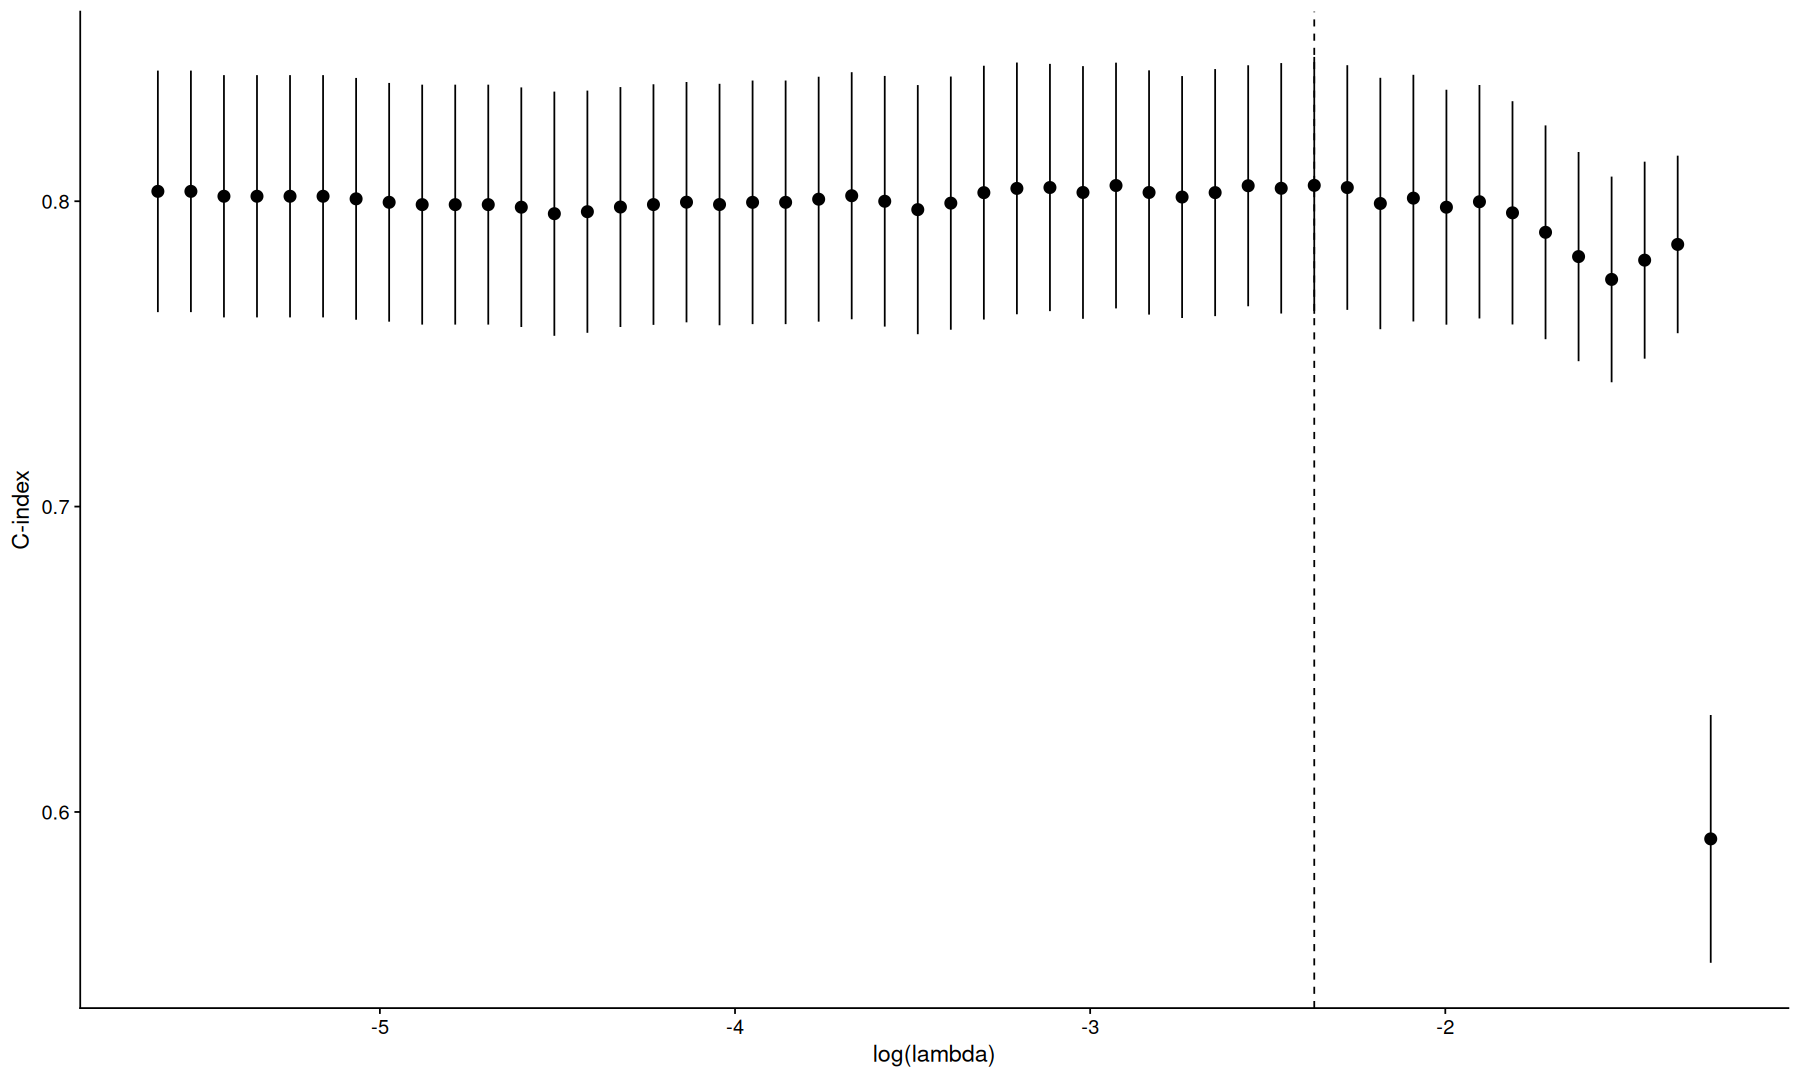

In [10]:
tidy(cvfit) |>
ggplot(aes(x=log(lambda), y=estimate)) +
geom_linerange(aes(ymin=conf.low, ymax=conf.high)) +
geom_point(size=3) +
geom_vline(xintercept=log(cvfit$lambda.min), linetype=2) +
labs(y='C-index')

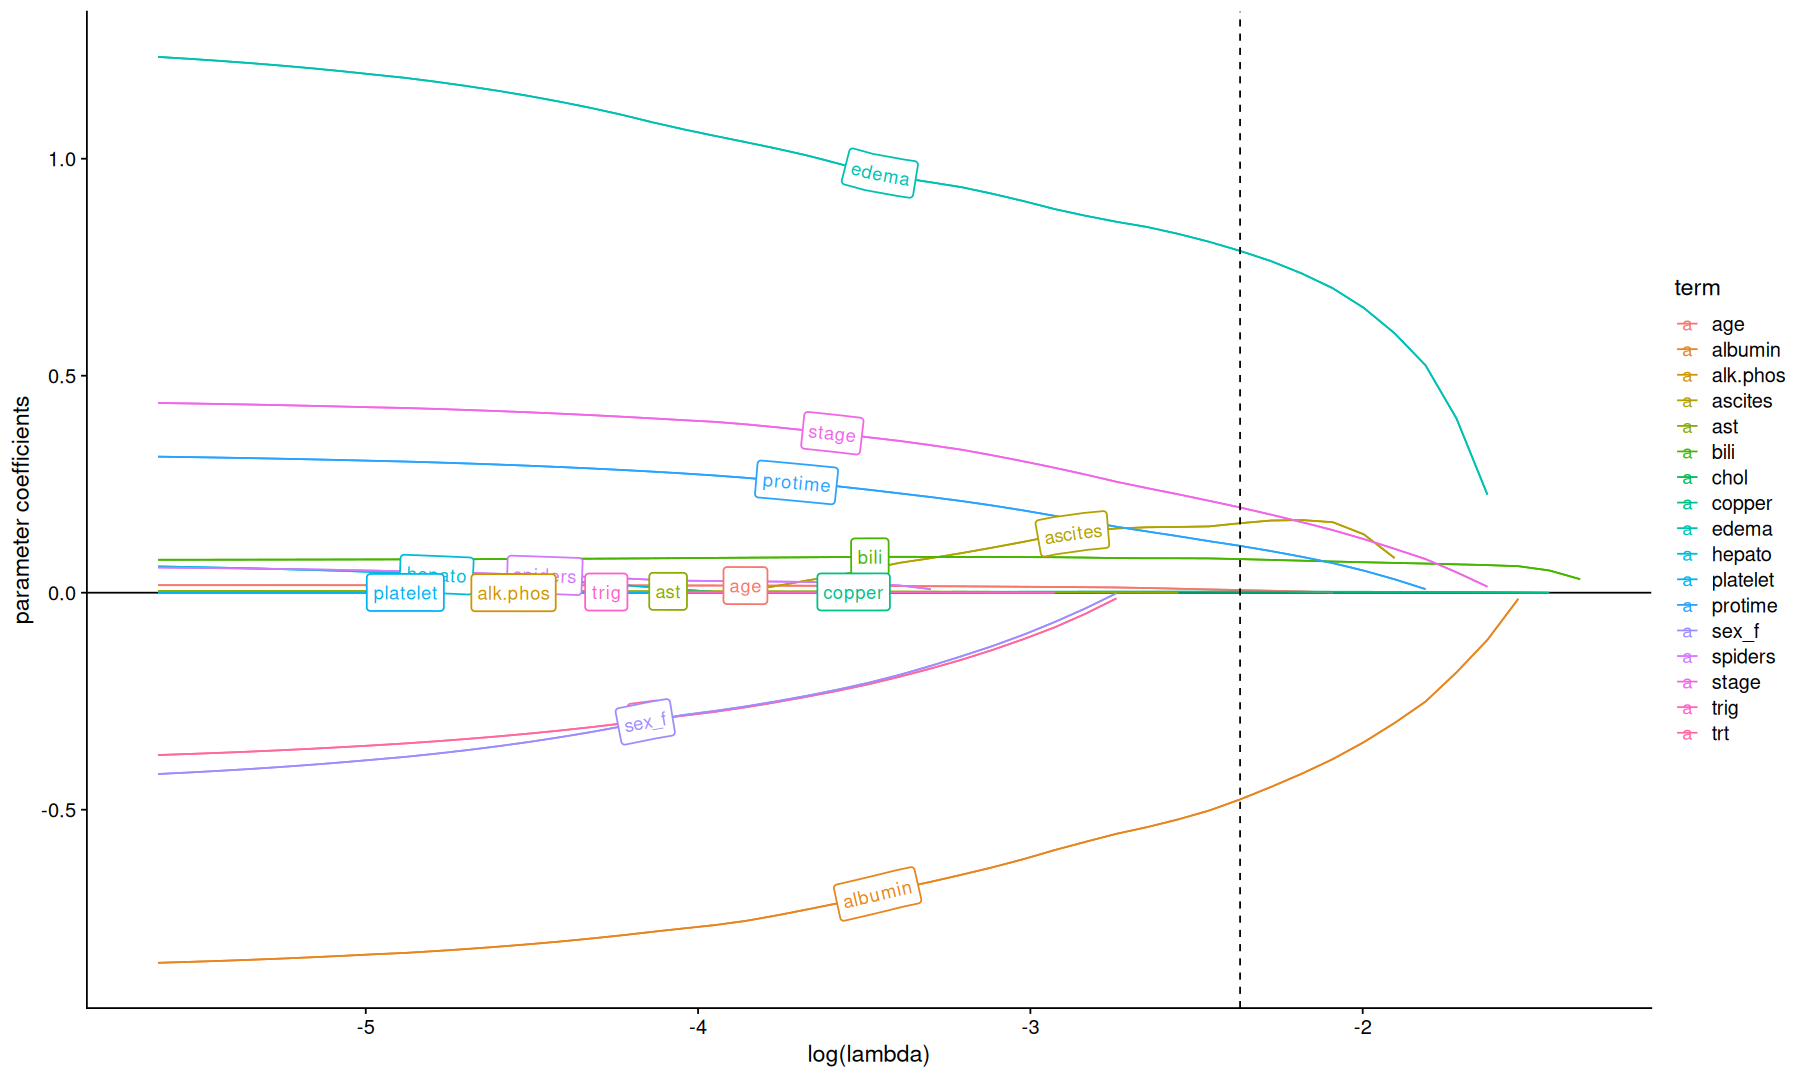

In [11]:
tidy(cvfit$glmnet.fit) |>
ggplot(aes(x=log(lambda), y=estimate, color=term)) +
geom_hline(yintercept=0) +
geom_line() +
geom_labelpath(aes(label=term)) +
geom_vline(xintercept=log(cvfit$lambda.min), linetype=2) +
labs(y='parameter coefficients')

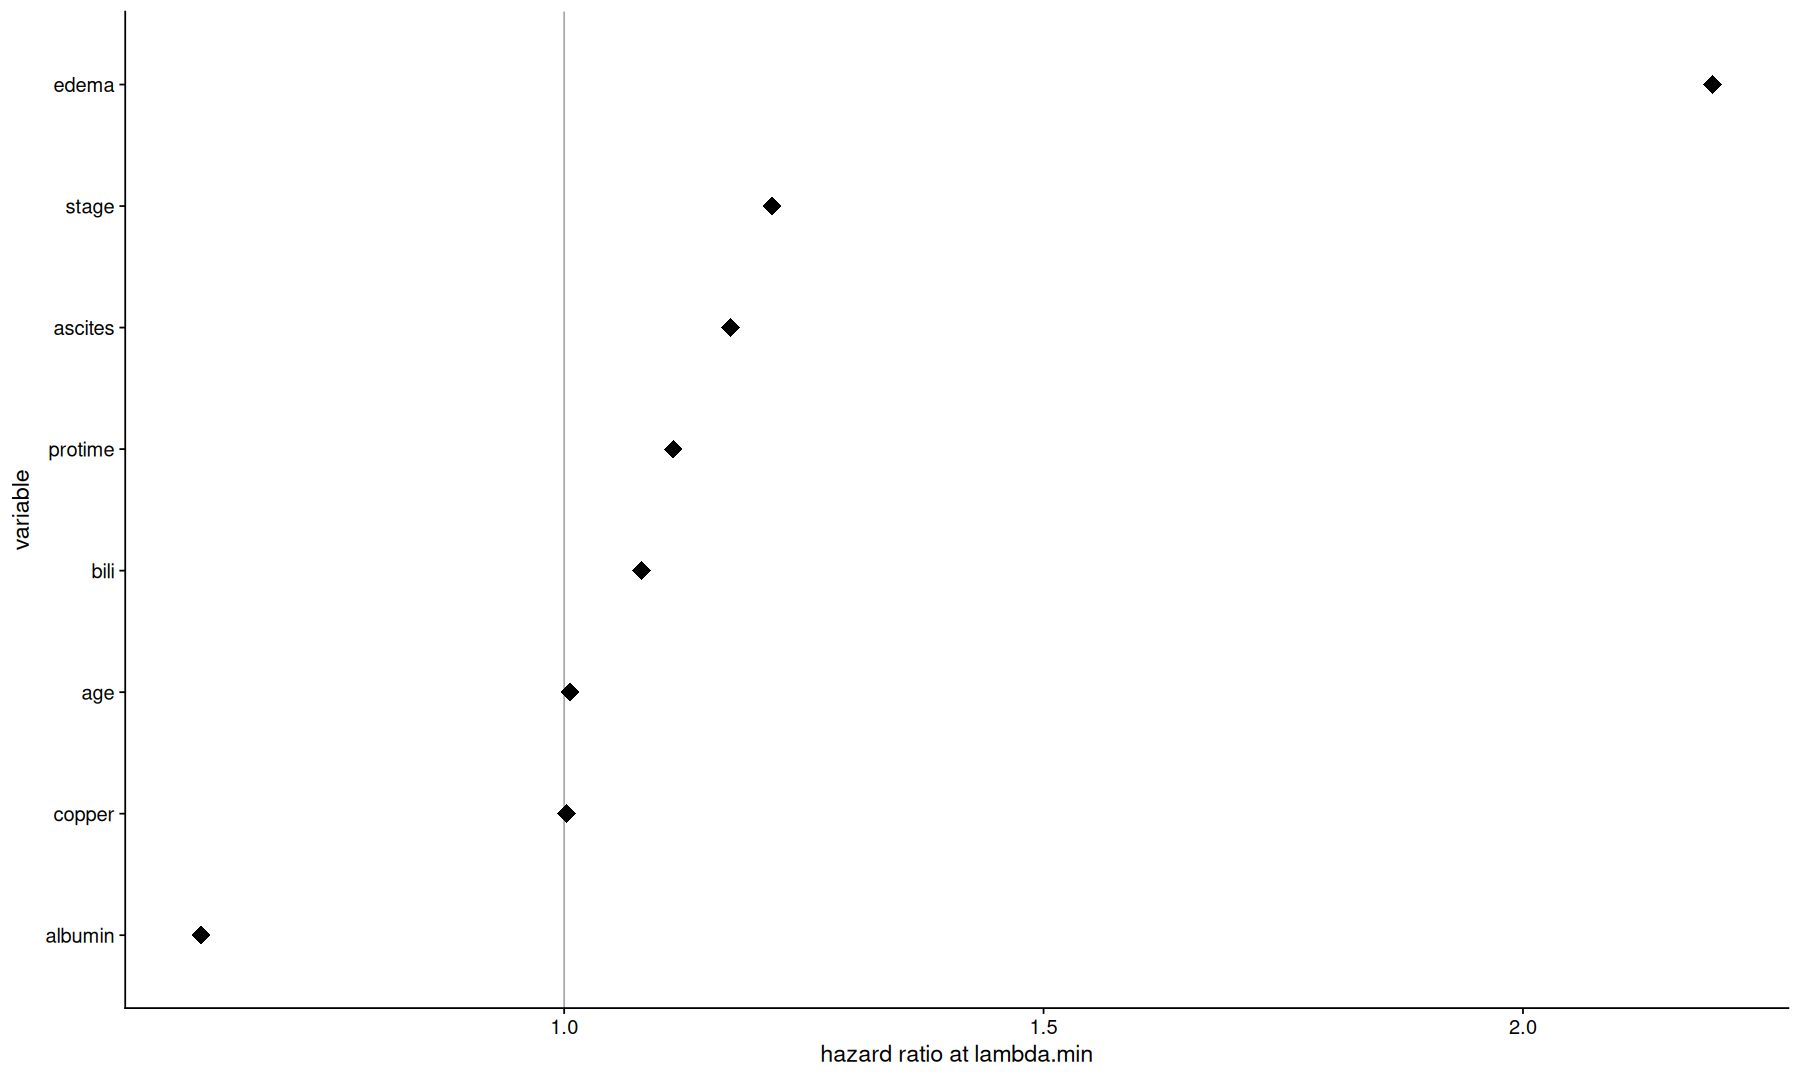

In [12]:
tidy(cvfit$glmnet.fit) |>
filter(lambda == cvfit$lambda.min) |>
mutate(exp.estimate=exp(estimate)) |>
ggplot(aes(x=exp.estimate, y=fct_reorder(term, estimate))) + 
geom_vline(xintercept=1, color='darkgray') +
geom_point(size=5, shape=18) +
labs(x='hazard ratio at lambda.min', y='variable')

In [13]:
test_data <- 
prep_rec |>
bake(new_data=testing(data_split))

In [14]:
test_data_x <- select(test_data, -surv) |> as.matrix()

In [15]:
z <- assess.glmnet(cvfit, newx=test_data_x, newy=test_data$surv, family='cox', s=c(cvfit$lambda.min))

In [16]:
z

$deviance
[1] 115.865001937706
attr(,"measure")
[1] "Partial Likelihood Deviance"

$C
[1] 0.884467265725289
attr(,"measure")
[1] "C-index"